In [42]:


import os

import numpy as np 
import pandas as pd 
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F     
import matplotlib.pyplot as plt


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
data_dir_train = '/home/wpanfil/Documents/Own_Projects/jezyki_skryptowe/proj5/flowers-recognition/flowers/train'
data_dir_validate = '/home/wpanfil/Documents/Own_Projects/jezyki_skryptowe/proj5/flowers-recognition/flowers/validate'
data_dir_test = '/home/wpanfil/Documents/Own_Projects/jezyki_skryptowe/proj5/flowers-recognition/flowers/test'

In [45]:
size_pictures = 100
data_transforms = transforms.Compose([transforms.Resize((size_pictures, size_pictures)),
                                 transforms.ToTensor()])

In [46]:
dataset = ImageFolder(root=data_dir_train,transform=data_transforms)
data_validate = ImageFolder(root=data_dir_validate,transform=data_transforms)
data_test = ImageFolder(root=data_dir_test,transform=data_transforms)
print(len(dataset), len(data_validate), len(data_test))

TypeError: ImageFolder.__init__() got an unexpected keyword argument 'num_workers'

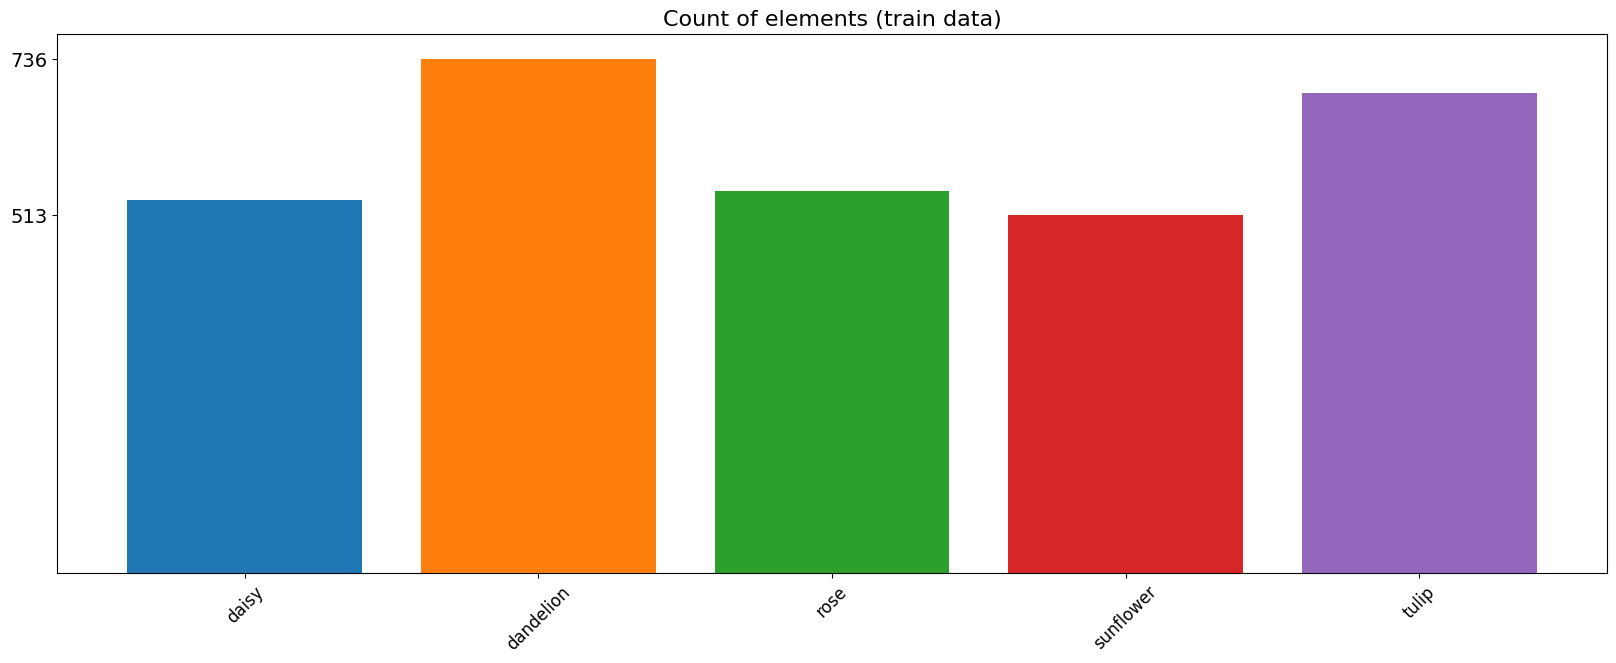

In [ ]:
labels_count = {}

for image in dataset.imgs:
    label = image[1]
    
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
    
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(20, 7));

for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);  
    
plt.title('Count of elements (train data)', fontsize=16)
plt.xticks(range(len(dataset.classes)), dataset.classes, rotation=45, fontsize=12)
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14)
plt.show()

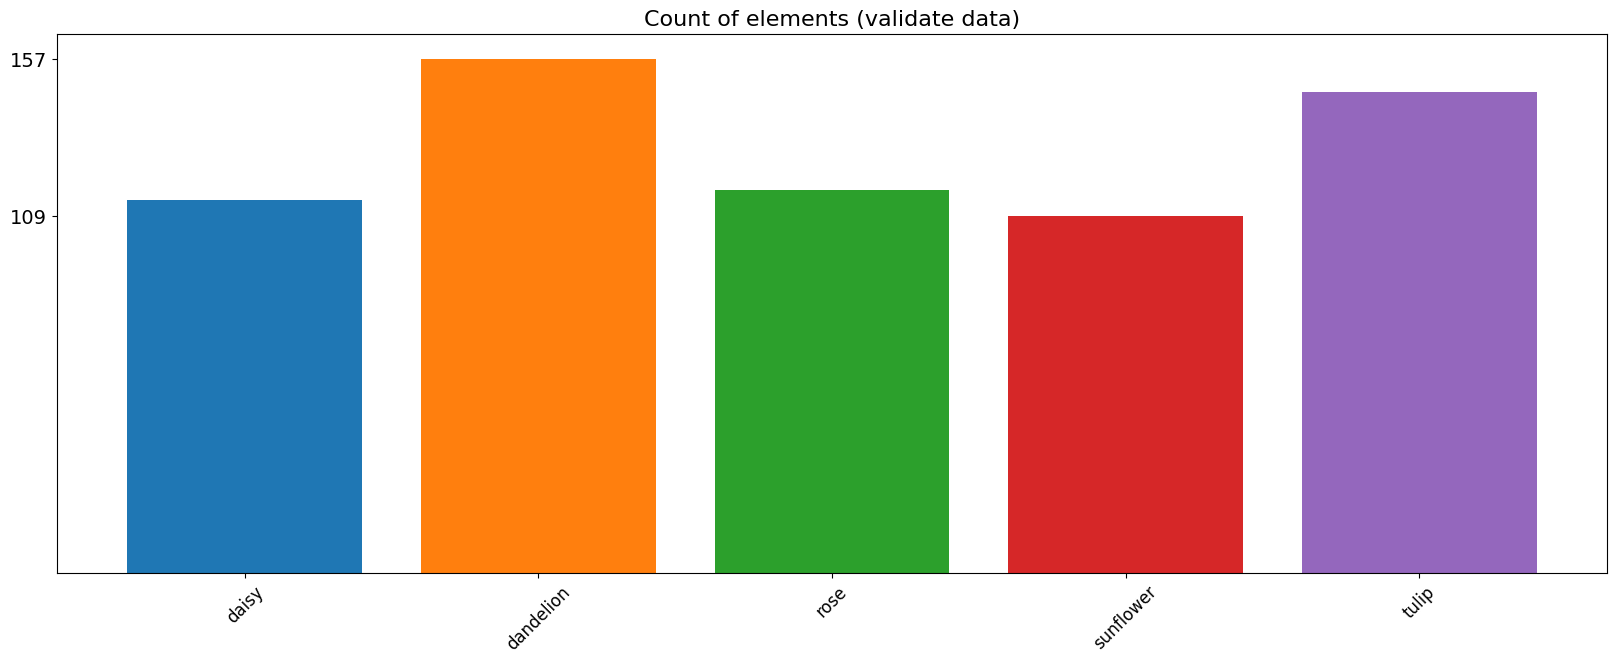

In [ ]:
labels_count = {}

for image in data_validate.imgs:
    label = image[1]
    
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
    
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(20, 7));

for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);  
    
plt.title('Count of elements (validate data)', fontsize=16)
plt.xticks(range(len(data_validate.classes)), data_validate.classes, rotation=45, fontsize=12)
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14)
plt.show()

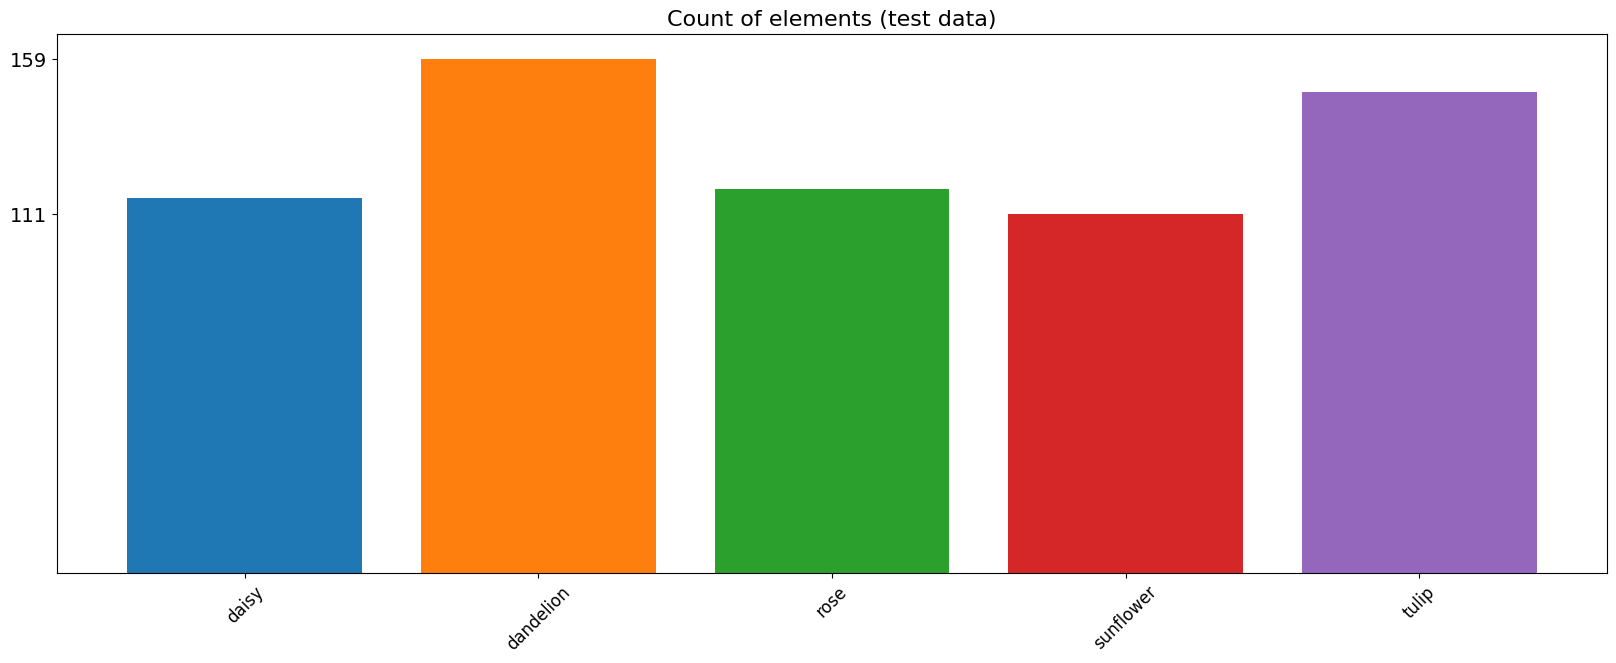

In [ ]:
labels_count = {}

for image in data_test.imgs:
    label = image[1]
    
    if label not in labels_count.keys():
        labels_count[label] = 0
    labels_count[label] += 1
    
class_counts = labels_count.copy()

#Visualize
plt.figure(figsize=(20, 7));

for n,key in enumerate(labels_count):
    plt.bar(list(labels_count.keys())[n],
            list(labels_count.values())[n]);  
    
plt.title('Count of elements (test data)', fontsize=16)
plt.xticks(range(len(data_test.classes)), data_test.classes, rotation=45, fontsize=12)
plt.yticks((min(list(labels_count.values())), max(list(labels_count.values()))), fontsize=14)
plt.show()

In [ ]:
def show_random_image():
    index = np.random.randint(0,len(dataset))
    return dataset[index]

In [ ]:
img, label = show_random_image()

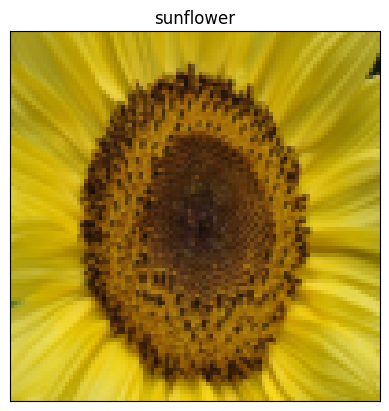

In [ ]:
img, label = show_random_image()
plt.title(dataset.classes[label])
plt.imshow(img.permute(1, 2, 0));
plt.xticks([]);
plt.yticks([]);

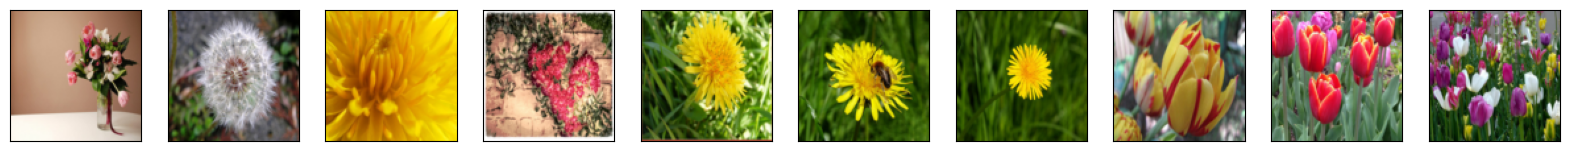

In [ ]:
fig = plt.figure(figsize=(20,5));
for i in range(1,11):
    
    
    img, label = show_random_image()
    plt.subplot(1,10, i,);
    plt.imshow(img.permute(1, 2, 0));
    plt.xticks([]);
    plt.yticks([]);

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=13, kernel_size=5, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=3, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=13, out_channels=27, kernel_size=5, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=3, stride=2)
        
        #6250
        self.fc1 = nn.Linear(13068,  3100)
        self.act3 = nn.ReLU()
        
        self.fc2 = nn.Linear(3100, 400)
        self.act4 = nn.Sigmoid()
        
        self.fc3 = nn.Linear(400, 131)
        
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)  
        
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        
        x = self.fc2(x)
        x = self.act4(x)
        
        x = self.fc3(x)
        return x

In [ ]:
model = NeuralNetwork()
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr=10 **(-3))
epoch = 7
batch_size = 256

In [ ]:
acc = []
def training(model, batch_size, epochs, loss, optimizer):
    for epoch in range(1, epochs + 1):        
        dataloader = DataLoader(dataset=dataset, 
                                batch_size=batch_size, 
                                shuffle=True)  
        model.train()
        for (X_batch,y_batch) in tqdm(dataloader): 
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model.forward(X_batch)
            
            loss_value = loss(preds, y_batch.long())
            loss_value.backward()
            
            optimizer.step()

        dataloader_validate = DataLoader(dataset=data_validate, 
                                        batch_size=256)
        model.eval()
        with torch.no_grad():
            summa = 0
            for (X_batch,y_batch) in tqdm(dataloader_validate):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)
                preds = torch.argmax(F.softmax(preds, dim=1), dim=1)
                correct = torch.eq(preds, y_batch.long())
                summa += torch.sum(correct).item()

            acc.append(summa / len(data_validate))
            print(f'epoch: {epoch}, acc:{acc[-1]:.2%}')

In [ ]:
%%time
training(model, batch_size, epoch, loss, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 1, acc:25.50%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 2, acc:25.50%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 3, acc:20.53%


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

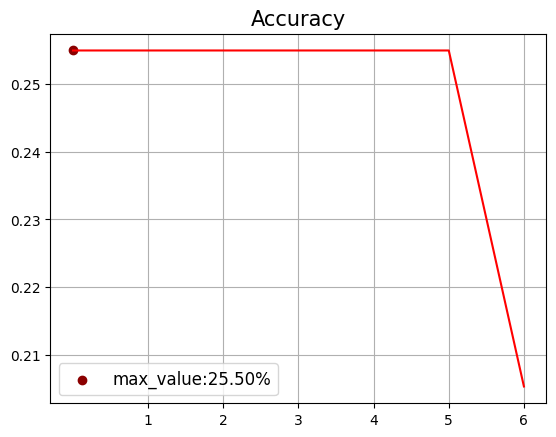

In [ ]:
acc_max = max(acc)
y_acc_max = acc.index(max(acc))
plt.title('Accuracy', fontsize = 15 )
plt.xticks(np.arange(1, epoch))
plt.scatter( y_acc_max, acc_max, color='darkred', label = f'max_value:{acc_max:.2%}')
plt.plot(acc, color='red', )
plt.grid()
plt.legend(fontsize = 12)

In [ ]:
dataloader_test = DataLoader(dataset=data_test, batch_size=256)
summa = 0
y_true = []
y_pred = []
for (X_batch,y_batch) in tqdm(dataloader_test):
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    preds = model.forward(X_batch)
    val_predict_class = preds.argmax(dim=-1)

    y_pred.extend([predict_class.item() for predict_class in val_predict_class])
    y_true.extend([val_label.item() for val_label in y_batch])

print(f'acc:{accuracy_score(y_true, y_pred):.2%}')

  0%|          | 0/3 [00:00<?, ?it/s]

acc:22.78%
